In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest

In [12]:
df_train=pd.read_csv("../../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../../ravdess_features_test_pulito.csv")

In [13]:
df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])

In [4]:
df_train.drop(axis="index", labels=[35,243,451,554,563,658,659,1031,1075,1283], inplace=True)
X_train=df_train.drop(columns=["emotion"]).values
y_train=df_train.emotion.values

df_test.drop(axis="index", labels=[33,34,138,196,197,198,199], inplace=True)
X_test=df_test.drop(columns=["emotion"]).values
y_test=df_test.emotion.values

In [14]:
sel = SelectKBest(k=108)
X_train = sel.fit_transform(X_train, y_train)
X_test = sel.transform(X_test)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [108] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
X_train.shape

(1828, 108)

# XGBoost

### Parametri importanti:

- #### General parameters:
    
    - booster: gbtree, gblinear or dart. default gbtree.


- #### Booster parameters:

    - eta: learning rate. [0,$\infty$], tipically 0.01-0.2;
    - gamma: min_split_loss. The larger the more conservative;
    - max_depth: tipically 3-10;
    - min_child_weight: prevent the model from learning very specific relations. [0,$\infty$];
    - subsample: denotes the fraction of observations to be randomly sampled for each tree. Tipically 0.5-1;
    - reg_lambda: L2 regularization;
    

- #### Learning task parameters:

    - objective: [multi:softmax, multi:softprob];
    - eval_metric: [merror, mlogloss]

Nota: enable_categorical non ha alcun effetto, almeno sulle variabili binarie che abbiamo noi.


In [7]:
#XGBClassifier?

In [8]:
clf = XGBClassifier(objective='multi:softmax',
                    booster="gbtree",
                    max_depth = 6,
                    learning_rate = 1.0,
                    gamma = 0.0,
                    reg_lambda = 1,
                    tree_method='approx', # 'approx'
                    random_state=42,
                    nthread=-1,
                    eval_metric="mlogloss"
                   )
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.47435897435897434
F1-score [0.41333333 0.71489362 0.36082474 0.4        0.41666667 0.5106383
 0.33519553 0.52252252]
              precision    recall  f1-score   support

           0       0.57      0.32      0.41        96
           1       0.60      0.88      0.71        96
           2       0.36      0.36      0.36        96
           3       0.40      0.40      0.40        48
           4       0.42      0.42      0.42        48
           5       0.52      0.50      0.51        96
           6       0.36      0.31      0.34        96
           7       0.46      0.60      0.52        48

    accuracy                           0.47       624
   macro avg       0.46      0.47      0.46       624
weighted avg       0.47      0.47      0.46       624



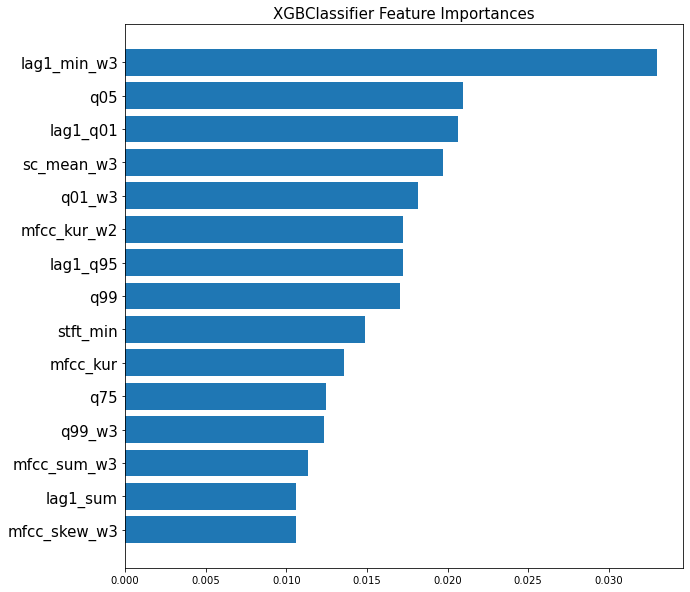

In [9]:
num_features=15
sorted_idx = clf.feature_importances_.argsort()[-num_features:]
plt.figure(figsize=(10,10))
plt.yticks(fontsize=15)
plt.barh(df_train.drop(columns=["emotion"]).columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.title("XGBClassifier Feature Importances", fontsize=15)
plt.show()

In [16]:
from scikitplot.metrics import plot_roc

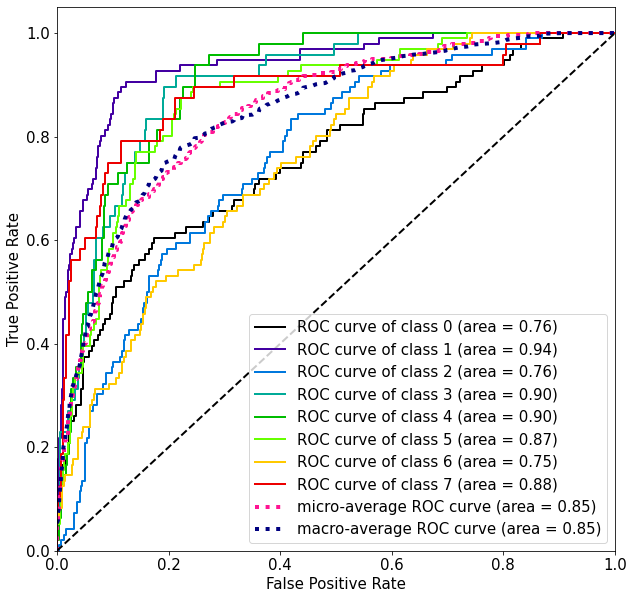

In [11]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score, figsize=(10,10), title_fontsize=15, text_fontsize=15)
#plt.legend(["AUC of class fearful = 0.76", "AUC of class angry = 0.92", "AUC of class happy = 0.78", "AUC of class surprised = 0.89", "AUC of class neutral = 0.92", "AUC of class calm = 0.90", "AUC of class sad = 0.74", "AUC of class disgust = 0.89", "micro-avg AUC = 0.85", "macro-avg AUC = 0.85"], fontsize=15)
plt.title("")
plt.show()

In [12]:
'''
xgb.plot_importance(clf, max_num_features=15)
plt.figure(figsize = (16, 12))
plt.show()
'''

'\nxgb.plot_importance(clf, max_num_features=15)\nplt.figure(figsize = (16, 12))\nplt.show()\n'

In [13]:
'''
param_list = {
    "booster": ["gbtree", "dart"],
    "eta": [x for x in np.linspace(0.01,0.2,num=int(0.2/0.01))],
    "gamma": [x for x in np.linspace(0,2,num=5)],
    "max_depth": [3,6,8,10],
    "min_child_weight": [x for x in np.linspace(1,8,num=8)],
    "subsample": [x for x in np.linspace(0.5,1,num=5)],
    "reg_lambda": [x for x in np.linspace(0.5,10,num=10)],
    "objective": ["multi:softmax", "multi:softprob"],
    "eval_metric": ["merror", "mlogloss"]
             }

grid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=300)
grid_xgboost.fit(X_train, y_train)
'''

'\nparam_list = {\n    "booster": ["gbtree", "dart"],\n    "eta": [x for x in np.linspace(0.01,0.2,num=int(0.2/0.01))],\n    "gamma": [x for x in np.linspace(0,2,num=5)],\n    "max_depth": [3,6,8,10],\n    "min_child_weight": [x for x in np.linspace(1,8,num=8)],\n    "subsample": [x for x in np.linspace(0.5,1,num=5)],\n    "reg_lambda": [x for x in np.linspace(0.5,10,num=10)],\n    "objective": ["multi:softmax", "multi:softprob"],\n    "eval_metric": ["merror", "mlogloss"]\n             }\n\ngrid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=300)\ngrid_xgboost.fit(X_train, y_train)\n'

In [14]:
#grid_xgboost.best_params_

Best params model complete (only OD): {'subsample': 0.875,
 'reg_lambda': 0.5,
 'objective': 'multi:softmax',
 'min_child_weight': 4.0,
 'max_depth': 8,
 'gamma': 0.5,
 'eval_metric': 'mlogloss',
 'eta': 0.12,
 'booster': 'dart'}

Best params model with FS and OD: {'subsample': 0.75,
 'reg_lambda': 7.888888888888889,
 'objective': 'multi:softmax',
 'min_child_weight': 3.0,
 'max_depth': 6,
 'gamma': 0.0,
 'eval_metric': 'mlogloss',
 'eta': 0.19,
 'booster': 'gbtree'}

In [20]:
eval_set = [(X_train, y_train), (X_test, y_test)]

subsample = 0.75,
• reg_lambda = 7.9,
• objective’: multi:softmax,
• min_child_weight = 3.0,
• max_depth = 6,
• gamma = 0.0,
• eval_metric = mlogloss,
• eta = 0.19,
• booster = gbtreex
DATASET2

In [21]:
clf = XGBClassifier(objective='multi:softmax',
                    booster="gbtree",
                    max_depth = 6,
                    gamma = 0.0,
                    eta=0.19,
                    reg_lambda = 7.9,
                    min_child_weight=3,
                    random_state=42,
                    nthread=-1,
                    subsample=0.75,
                    eval_metric="mlogloss",
                    n_estimators=500,
                    early_stopping_rounds=10
                   )
clf.fit(X_train, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.90544	validation_1-mlogloss:1.97274
[1]	validation_0-mlogloss:1.76426	validation_1-mlogloss:1.88147
[2]	validation_0-mlogloss:1.64353	validation_1-mlogloss:1.80873
[3]	validation_0-mlogloss:1.53503	validation_1-mlogloss:1.75319
[4]	validation_0-mlogloss:1.43761	validation_1-mlogloss:1.70268
[5]	validation_0-mlogloss:1.35082	validation_1-mlogloss:1.65490
[6]	validation_0-mlogloss:1.27632	validation_1-mlogloss:1.62414
[7]	validation_0-mlogloss:1.20290	validation_1-mlogloss:1.59051
[8]	validation_0-mlogloss:1.14126	validation_1-mlogloss:1.56256
[9]	validation_0-mlogloss:1.08542	validation_1-mlogloss:1.54312
[10]	validation_0-mlogloss:1.03352	validation_1-mlogloss:1.52241
[11]	validation_0-mlogloss:0.98504	validation_1-mlogloss:1.50602
[12]	validation_0-mlogloss:0.93892	validation_1-mlogloss:1.48995
[13]	validation_0-mlogloss:0.89712	validation_1-mlogloss:1.47383
[14]	validation_0-mlogloss:0.85654	validation_1-mlogloss:1.46587
[15]	validation_0-mlogloss:0.82111	

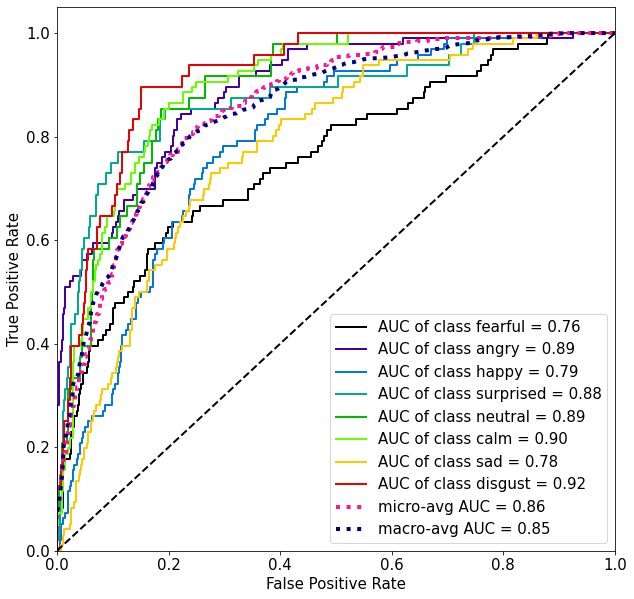

In [23]:
y_score = clf.predict_proba(X_test)
plot_roc(y_test, y_score, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.legend(["AUC of class fearful = 0.76", "AUC of class angry = 0.89", "AUC of class happy = 0.79", "AUC of class surprised = 0.88", "AUC of class neutral = 0.89", "AUC of class calm = 0.90", "AUC of class sad = 0.78", "AUC of class disgust = 0.92", "micro-avg AUC = 0.86", "macro-avg AUC = 0.85"], fontsize=15)
plt.title("")
plt.show()

In [18]:
results = clf.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

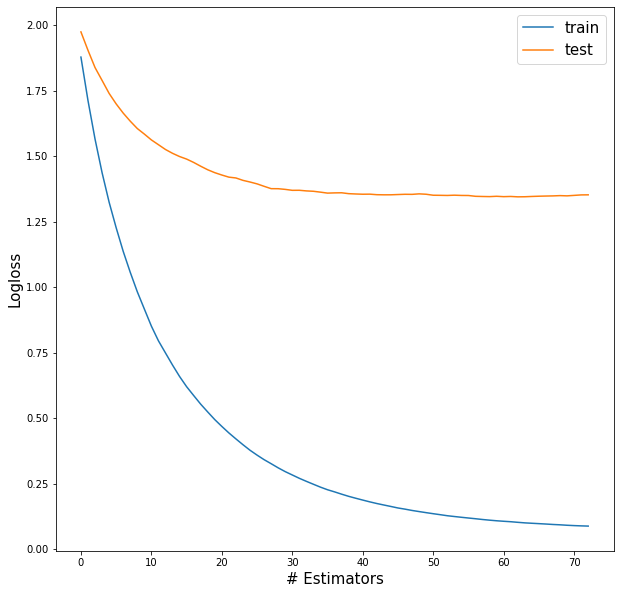

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='test')
ax.legend(fontsize=15)
plt.ylabel('Logloss', fontsize=15)
plt.xlabel("# Estimators", fontsize=15)
#plt.title('XGBoost Logloss')
plt.show()

In [20]:
'''
param_list = {
    "booster": ["dart"],
    "eta": [0.12],
    "gamma": [x for x in np.linspace(0,0.5,num=100)],
    "max_depth": [3,6,8,10],
    "min_child_weight": [x for x in np.linspace(1,8,num=8)],
    "subsample": [0.875],
    "reg_lambda": [x for x in np.linspace(0,0.5,num=100)],
    "objective": ["multi:softmax", "multi:softprob"],
    "eval_metric": ["mlogloss"]
             }

grid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),
                    param_distributions=param_list,
                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),
                    n_jobs=-1,
                    n_iter=300,
                    verbose=4)
grid_xgboost.fit(X_train, y_train)
'''

'\nparam_list = {\n    "booster": ["dart"],\n    "eta": [0.12],\n    "gamma": [x for x in np.linspace(0,0.5,num=100)],\n    "max_depth": [3,6,8,10],\n    "min_child_weight": [x for x in np.linspace(1,8,num=8)],\n    "subsample": [0.875],\n    "reg_lambda": [x for x in np.linspace(0,0.5,num=100)],\n    "objective": ["multi:softmax", "multi:softprob"],\n    "eval_metric": ["mlogloss"]\n             }\n\ngrid_xgboost = RandomizedSearchCV(XGBClassifier(nthread=-1),\n                    param_distributions=param_list,\n                    cv=RepeatedStratifiedKFold(random_state=0, n_splits=3, n_repeats=5),\n                    n_jobs=-1,\n                    n_iter=300,\n                    verbose=4)\ngrid_xgboost.fit(X_train, y_train)\n'

In [21]:
#grid_xgboost.best_params_

New best params: {'subsample': 0.875,
 'reg_lambda': 0.030303030303030304,
 'objective': 'multi:softprob',
 'min_child_weight': 4.0,
 'max_depth': 10,
 'gamma': 0.16161616161616163,
 'eval_metric': 'mlogloss',
 'eta': 0.12,
 'booster': 'dart'}

In [22]:
clf = XGBClassifier(objective='multi:softprob',
                    booster="dart",
                    max_depth = 10,
                    gamma = 0.16161616161616163,
                    eta=0.12,
                    reg_lambda = 0.030303030303030304,
                    min_child_weight=4,
                    random_state=42,
                    nthread=-1,
                    subsample=0.875,
                    eval_metric="mlogloss",
                    early_stopping_rounds=10
                   )
clf.fit(X_train, y_train, eval_set=eval_set)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.86506	validation_1-mlogloss:1.97583
[1]	validation_0-mlogloss:1.68379	validation_1-mlogloss:1.89512
[2]	validation_0-mlogloss:1.52828	validation_1-mlogloss:1.83209
[3]	validation_0-mlogloss:1.39326	validation_1-mlogloss:1.77752
[4]	validation_0-mlogloss:1.27213	validation_1-mlogloss:1.72184
[5]	validation_0-mlogloss:1.16730	validation_1-mlogloss:1.68494
[6]	validation_0-mlogloss:1.07501	validation_1-mlogloss:1.65134
[7]	validation_0-mlogloss:0.98842	validation_1-mlogloss:1.62325
[8]	validation_0-mlogloss:0.91060	validation_1-mlogloss:1.60119
[9]	validation_0-mlogloss:0.84364	validation_1-mlogloss:1.57827
[10]	validation_0-mlogloss:0.78194	validation_1-mlogloss:1.55602
[11]	validation_0-mlogloss:0.72428	validation_1-mlogloss:1.54013
[12]	validation_0-mlogloss:0.67390	validation_1-mlogloss:1.51998
[13]	validation_0-mlogloss:0.62837	validation_1-mlogloss:1.50750
[14]	validation_0-mlogloss:0.58815	validation_1-mlogloss:1.49173
[15]	validation_0-mlogloss:0.54866	

In [23]:
results = clf.evals_result_
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

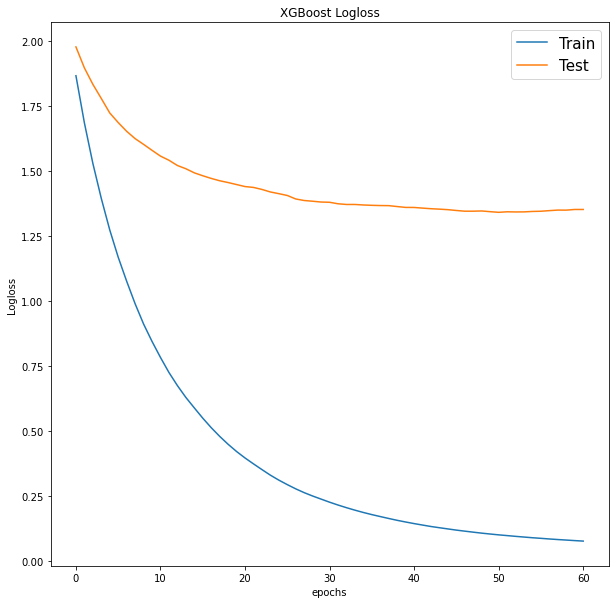

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend(fontsize=15)
plt.ylabel('Logloss')
plt.xlabel("epochs")
plt.title('XGBoost Logloss')
plt.show()